Product 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import xlrd
from datetime import datetime as dt
import time

discharge_df = pd.read_csv('discharge.txt', skiprows=27, sep='\t').drop(0, axis=0).rename(columns={'111434_00060_00003':'discharge (ft^3/sec)','111434_00060_00003_cd':'code' })

discharge_df['datetime'] = pd.to_datetime(discharge_df['datetime'])

def toYearFraction(date):
    """
    https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years
    """
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

discharge_df['Decimal Year'] = discharge_df['datetime'].apply(lambda x: toYearFraction(x))
discharge_df = discharge_df.set_index('datetime')

In [7]:
#http://benalexkeen.com/resampling-time-series-data-with-pandas/
discharge_df['10 Day Minimum Discharge'] = discharge_df['discharge (ft^3/sec)'].resample('10D').min().resample('1D').ffill().astype(float)

discharge_df['30 Day Minimum Discharge'] = discharge_df['discharge (ft^3/sec)'].resample('30D').min().resample('1D').ffill().astype(float)

discharge_df['90 Day Minimum Discharge'] = discharge_df['discharge (ft^3/sec)'].resample('90D').min().resample('1D').ffill().astype(float)

discharge_df['discharge (ft^3/sec)'] = discharge_df['discharge (ft^3/sec)'].astype(float)

Should we remove outliers to get a better sense of how resampling affects the baseflow estimate?

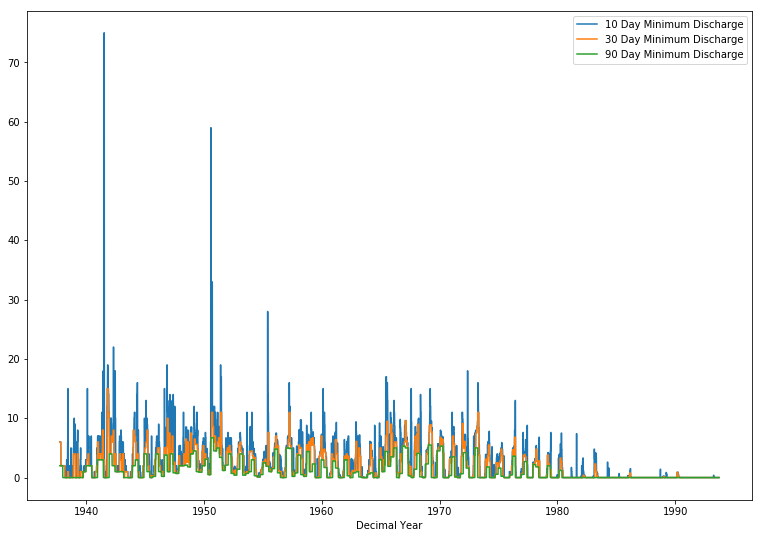

In [8]:
discharge_df.plot(x='Decimal Year',y=['10 Day Minimum Discharge','30 Day Minimum Discharge','90 Day Minimum Discharge'], figsize=(13,9))

In [27]:
yearly_discharge = pd.DataFrame()
yearly_discharge['10 Day Minimum Discharge 2 Year Rolling Mean'] = discharge_df['10 Day Minimum Discharge'].resample('1Y').sum().rolling(window=2).mean()
yearly_discharge['30 Day Minimum Discharge 2 Year Rolling Mean'] = discharge_df['30 Day Minimum Discharge'].resample('1Y').sum().rolling(window=2).mean()
yearly_discharge['90 Day Minimum Discharge 2 Year Rolling Mean'] = discharge_df['90 Day Minimum Discharge'].resample('1Y').sum().rolling(window=2).mean()

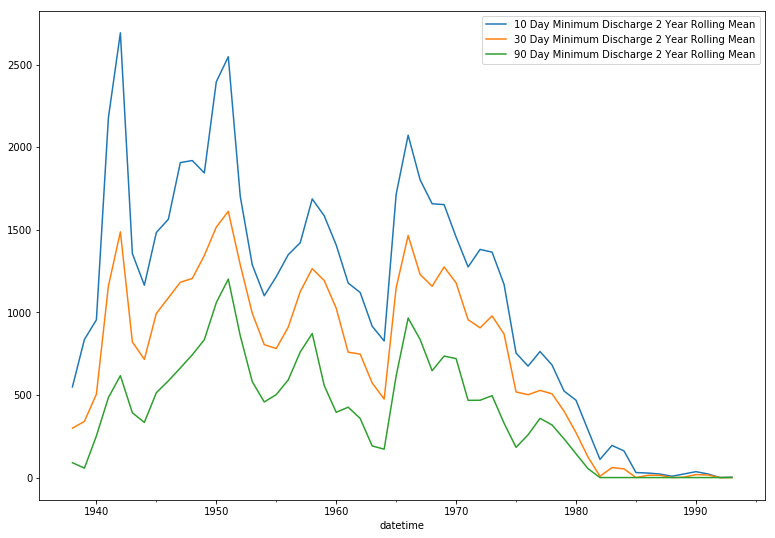

In [29]:
yearly_discharge.plot(y=['10 Day Minimum Discharge 2 Year Rolling Mean','30 Day Minimum Discharge 2 Year Rolling Mean','90 Day Minimum Discharge 2 Year Rolling Mean'], figsize=(13,9))

Product 3

Our baseflow estimates show that baseflow was overall much higher the earlier in the time series you examine. There is a considerable drop off in the baseflow estimation no matter what resampling window is used that really gets going around 1970 all the way through 1990 and the end of the data record. Periodic drought signals are clearly apparent throughout the time series where there are large declines in the baseflow estimate, particularly around 1964, 1954, and 1945. These are spaced roughly equally apart which might indicate there is some climate system that causes this (like ENSO?). The trends for each of the resampling intervals show that a larger resampling window will result in lower baseflow estimates because the larger window will capture more lower minimum flows than a smaller window, causing larger minimum flows to be masked out of the resulting estimate.

Product 4

In [60]:
gw_levels = pd.read_csv("gwlevels.csv", skiprows=81, sep='\t').drop(0, axis=0).drop(['site_tp_cd', 'lev_tm', 'lev_tz_cd', 'sl_lev_va', 'sl_datum_cd', 'lev_status_cd', 'lev_agency_cd'], axis=1)
gw_levels = gw_levels.rename(columns={'lev_va':'Water level, feet below land surface', 'lev_dt':'Date'})

gw_levels['datetime'] = pd.to_datetime(gw_levels['Date'])
gw_levels['Decimal Year'] = gw_levels['datetime'].apply(lambda x: toYearFraction(x))
gw_levels['Water level, feet below land surface'] = gw_levels['Water level, feet below land surface'].astype(float)

Elevation of the Well Water

In [83]:
gw_levels['Well Water Elevation (Hydraulic Head)'] = gw_levels['Water level, feet below land surface'].apply(lambda x: 3430 - x)
gw_levels['Difference between well water level and river level'] = gw_levels['Water level, feet below land surface'].apply(lambda x: 3430 - x - 3230)
gw_levels

,agency_cd,site_no,Date,"Water level, feet below land surface",lev_dt_acy_cd,lev_acy_cd,lev_src_cd,lev_meth_cd,lev_age_cd,datetime,Decimal Year,Well Water Elevation (Hydraulic Head),Difference between well water level and river level
1,USGS,363033101440701,1956-07-26,188.95,D,2,U,S,A,1956-07-26,1956.565460,3241.05,11.05
2,USGS,363033101440701,1956-08-05,189.03,D,2,U,B,A,1956-08-05,1956.592782,3240.97,10.97
3,USGS,363033101440701,1956-08-10,189.03,D,2,U,B,A,1956-08-10,1956.606444,3240.97,10.97
4,USGS,363033101440701,1956-08-15,189.02,D,2,U,B,A,1956-08-15,1956.620105,3240.98,10.98
5,USGS,363033101440701,1956-08-20,189.09,D,2,U,B,A,1956-08-20,1956.633766,3240.91,10.91
6,USGS,363033101440701,1956-08-25,189.00,D,2,U,B,A,1956-08-25,1956.647427,3241.00,11.00
7,USGS,363033101440701,1956-08-29,188.94,D,2,U,B,A,1956-08-29,1956.658356,3241.06,11.06
8,USGS,363033101440701,1956-09-03,188.99,D,2,U,B,A,1956-09-03,1956.672017,3241.01,11.01
9,USGS,363033101440701,1956-09-10,189.00,D,2,U,B,A,1956-09-10,1956.691143,3241.00,11.00
10,USGS,363033101440701,1956-09-15,188.99,D,2,U,B,A,1956-09-15,1956.704804,3241.01,11.01


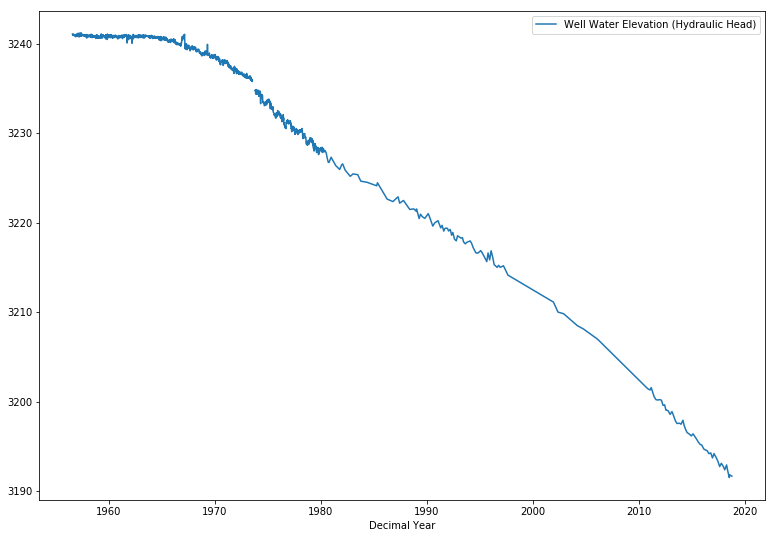

In [79]:
gw_levels.plot(x = 'Decimal Year', y='Well Water Elevation (Hydraulic Head)', figsize=(13, 9))

Product 5

The groundwater level in the well have steadily declined in the monitoring well. It's not a completely linear pattern, from about 1955 until about 1975 the decline seemed to follow an exponential decay pattern. After the mid 1970s the decline seems to follow a linear pattern.

Rate of Change from 1960 until 1970

In [85]:
gw_levels = gw_levels.set_index('datetime')

In [89]:
gw_levels_1960_1970 = gw_levels['1960-01-01':'1970-12-31']
gw_levels_1980_1990 = gw_levels['1980-01-01':'1990-12-31']

In [94]:
(gw_levels_1980_1990['Well Water Elevation (Hydraulic Head)'].iloc[-1] - gw_levels_1980_1990['Well Water Elevation (Hydraulic Head)'].iloc[0]) / (gw_levels_1980_1990['Decimal Year'].iloc[-1] - gw_levels_1980_1990['Decimal Year'].iloc[0])

-0.7714218532423462

From 1980 to 1990 the absolute averaged change is a decrease of .77 feet per each decimal year. 

Do we need to fit exponential and linear curves to each section to determine rates of change?

Rate of Change from 1980 until 1990

In [78]:
flowlines = gpd.read_file('beaver_gis/BeaverRiverFlowlines.shp')
constructed_wells = gpd.read_file('beaver_gis/ConstructedWells.shp')

In [30]:
beaver_df = pd.ExcelFile("streamflow_depletion_to_class.xlsx").parse()

# Product 7

maximum contribution of each well to stream depletion assumes all reduction in hydraulic head corressponds to reduction in baseflow